In [109]:

import numpy as np
from scipy import io
import os, sys, time
import netCDF4 as nc
from transform_functions import sfun, sfun_invint
from scipy import optimize
import lmoments3 as lm
from scipy.special import erfc, erfinv


def of_fun(param, p, num):
    pt = sfun(p, num, param)
    # lmoms = lmom.samlmu(pt, nmom=4)
    lmoms = lm.lmom_ratios(pt, nmom=4)
    l_skewness = lmoms[2]
    l_kurtosis = lmoms[3]
    of = (l_skewness) ** 2 + (l_kurtosis - 0.1226) ** 2
    return of

def of_solve_para(i, pi, tn1, tn2):
    out = np.zeros([tn2-tn1+1,2])
    # for t in range(3, 20):
    for t in range(tn1-1, tn2):
        paramrc = optimize.fmin(of_fun, 0.1, (pi, t + 1), disp=False)
        out[t-tn1+1, 0] = paramrc
        out[t-tn1+1, 1] = of_fun(paramrc, pi, t + 1)
    return (i, out)

def trans_prcp(p, tn, param):
    p = p.copy()
    ind = p > 0
    p[~ind] = np.nan
    if np.sum(ind) > 0:
        p[ind] = sfun(p[ind], tn, param)
    return p

def idw_int(data, ll1, ll2):
    # inverse distance interpolation
    num = np.shape(ll2)[0]
    dout = np.nan * np.zeros(num)
    ind = ~np.isnan(data)
    if np.sum(ind) > 10:
        ll1 = ll1[ind, :]
        data = data[ind]
        for i in range(num):
            dist = (ll1[:,0]-ll2[i,0]) ** 2 + (ll1[:,1]-ll2[i,1]) ** 2
            dsort = np.argsort(dist)
            dsort = dsort[:10] # we use 10 stations here
            dist = dist[dsort]
            weight = 1/dist
            weight = weight/np.sum(weight)
            dout[i] = np.sum(weight * data[dsort])
    return dout

def findmax(data, ll1, ll2):
    num = np.shape(ll2)[0]
    ind = ~np.isnan(data)
    ll1 = ll1[ind, :]
    data = data[ind]
    dout = np.nan * np.zeros(num)
    for i in range(num):
        dist = (ll1[:, 0] - ll2[i, 0]) ** 2 + (ll1[:, 1] - ll2[i, 1]) ** 2
        dsort = np.argsort(dist)
        dout[i] = np.max(data[dsort[:25]]) # we use 25 stations here
    return dout
        
########################################################################################################################

# time periods and methods
# year = int(sys.argv[1])  # prcp only
# transn = int(sys.argv[2])
# month = [1, 12]
year = 2016  # prcp only
transn = 1
month = [1, 2]

########################################################################################################################

### Local Mac settings
# input files/paths
FileGridInfo = '/Users/localuser/Research/EMDNA/basicinfo/gridinfo_whole.nc'
path_bac = '/Users/localuser/Research/EMDNA/merge' # data that will be used as background
path_obs = '/Users/localuser/Research/EMDNA/regression' # data that will be used as observation
near_file_GMET = '/Users/localuser/Research/EMDNA/regression/weight_nearstn.npz' # near station of stations/grids
file_mask = './DEM/NA_DEM_010deg_trim.mat'
FileStnInfo = '/Users/localuser/Research/EMDNA/basicinfo/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_aftercheck.npz'
filemerge_stn = '/Users/localuser/Research/EMDNA/OImerge_stn_GWRLSBMA_prcp.npz'

# output files/paths (can also be used as inputs once generated)
path_oimerge = '/Users/localuser/Research/EMDNA/oimerge'
path_oipop = path_oimerge
### Local Mac settings


### Graham settings
# input files/paths
# FileGridInfo = '/home/gut428/projects/rpp-kshook/gut428/EMDNA_new/StnGridInfo/gridinfo_whole.nc'
# gmet_stndatafile = '/home/gut428/projects/rpp-kshook/gut428/EMDNA_new/stndata_aftercheck.npz'
# file_mask = '/home/gut428/projects/rpp-kshook/gut428/EMDNA_new/DEM/NA_DEM_010deg_trim.mat'
# path_oimerge = '/home/gut428/projects/rpp-kshook/gut428/EMDNA_new/OImerge_GWRLSBMA'
# outpath = '/home/gut428/scratch/OIprcp_transform'
#
# near_file_GMET = '/datastore/GLOBALWATER/CommonData/EMDNA_new/stn_reg_aftercheck/nearstn_catalog.npz'

# for the transformation methods used, whether zero can be transformed
# allowzero = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
path_trans = '/Users/localuser/Research/EMDNA/OIprcp_transform'
path_validate = '/Users/localuser/Research/EMDNA/validate'
path_ensval = '/Users/localuser/Research/EMDNA/ens_evaluation'
path_scrf = '/Users/localuser/Research/EMDNA/scrf'


In [110]:

# basic processing
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels
nrows, ncols = np.shape(mask)

# meshed lat/lon of the target region
ncfid = nc.Dataset(FileGridInfo)
lattarm = ncfid.variables['latitude'][:].data
lattarm = np.flipud(lattarm)
lontarm = ncfid.variables['longitude'][:].data
ncfid.close()
lontar = lontarm[0, :]
lattar = lattarm[:, 0]

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
date_ymd = datatemp['date_ymd']
del datatemp
date_yyyy = (date_ymd / 10000).astype(int)
date_mm = (np.mod(date_ymd, 10000) / 100).astype(int)

########################################################################################################################

# load station points that will be used for testing
file = path_ensval + '/stn_prcp_' + str(year) + '.mat'
stndata0 = io.loadmat(file)
stnlle = stndata0['LLE']
stndata = stndata0['data_stn']
stndate = stndata0['date']
nstn = np.shape(stnlle)[0]

# calculate the grid index that corresponds to each stations
stnrc = np.zeros([nstn, 2], dtype=int)
for i in range(nstn):
    stnrc[i, 0] = np.argmin(np.abs(stnlle[i,0] - lattar))
    stnrc[i, 1] = np.argmin(np.abs(stnlle[i, 1] - lontar))

# extract data for the month
stnmm = (np.mod(stndate, 10000) / 100).astype(int)
ind = (stnmm >= month[0]) & (stnmm <= month[1])
stndate = stndate[ind]
stnmm = stnmm[ind]
stndata = stndata[np.squeeze(ind), :]

ndays = len(stndate)

In [111]:
# load transformation parameters
trans_param = np.nan * np.zeros([nstn, 12])
if transn > 3:
    for m in range(month[0]-1, month[1]):
        filem = path_trans + '/prcp_trans_param_' + str(m+1) + '_TN' + str(transn) + '-' + str(transn) + '.mat'
        datatemp = io.loadmat(filem)
        param = datatemp['param']
        for i in range(nstn):
            trans_param[i, m] = param[stnrc[i,0], stnrc[i,1], 0, 0]
        del param
        # constrain
        temp = trans_param[:, m]
        temp[temp>np.percentile(temp,99)] = np.percentile(temp,99)
        temp[temp < np.percentile(temp, 1)] = np.percentile(temp, 1)
        trans_param[:, m] = temp

In [112]:
oidata = np.nan * np.zeros([ndays, nstn])
oidata_raw = np.nan * np.zeros([ndays, nstn])
for m in range(month[0]-1, month[1]):
    fileoi = path_oimerge + '/oimerge_prcp' + str(year * 100 + m + 1) + '.npz'
    datatemp = np.load(fileoi)
    prcp = datatemp['oi_value']  # value in normal space
    del datatemp

    # extract data corresponding to station points and convert data from natural space to normal space
    # zero P will be nan
    indm = stnmm == m + 1
    ndaysm = np.shape(prcp)[2]
    for i in range(nstn):
        # prcp value
        oidata_raw[indm, i] = prcp[stnrc[i,0], stnrc[i,1], :]
        oidata[indm, i] = trans_prcp(prcp[stnrc[i,0], stnrc[i,1], :], transn, trans_param[i, m])
        

In [113]:

# load oimerge data at stations
datatemp = np.load(filemerge_stn)
oimerge_stn = datatemp['oimerge_stn']
oimerge_date = datatemp['date_ymd']
oimerge_stninfo = datatemp['stninfo']
oimerge_yyyy = (oimerge_date/10000).astype(int)
oimerge_stn = oimerge_stn[:, oimerge_yyyy == year]
oimerge_date = oimerge_date[oimerge_yyyy == year]
oimerge_mm = (np.mod(oimerge_date, 10000) / 100).astype(int)
del datatemp
nstn_all = np.shape(oimerge_stn)[0]

# load obs data at stations
datatemp = np.load(gmet_stndatafile)
obs_stn = datatemp['prcp_stn']
obs_stn = obs_stn[:, oimerge_yyyy == year]
del datatemp

ind = (oimerge_mm >= month[0]) & (oimerge_mm <= month[1])
oimerge_stn = oimerge_stn[:, ind]
obs_stn = obs_stn[:, ind]
oimerge_mm = oimerge_mm[ind]

# normal error at stations
stnrc_all = np.zeros([nstn_all, 2], dtype=int)
for i in range(nstn):
    stnrc_all[i, 0] = np.argmin(np.abs(oimerge_stninfo[i, 1] - lattar))
    stnrc_all[i, 1] = np.argmin(np.abs(oimerge_stninfo[i, 2] - lontar))

    
# load transformation parameters
trans_param_all = np.nan * np.zeros([nstn_all, 12])
if transn > 3:
    for m in range(month[0]-1, month[1]):
        filem = path_trans + '/prcp_trans_param_' + str(m+1) + '_TN' + str(transn) + '-' + str(transn) + '.mat'
        datatemp = io.loadmat(filem)
        param = datatemp['param']
        for i in range(nstn):
            trans_param_all[i, m] = param[stnrc_all[i,0], stnrc_all[i,1], 0, 0]
        del param
        # constrain
        temp = trans_param_all[:, m]
        upb = np.percentile(temp[~np.isnan(temp)],99)
        lwb = np.percentile(temp[~np.isnan(temp)],1)
        temp[temp> upb] = upb
        temp[temp < lwb] = lwb
        trans_param_all[:, m] = temp

In [114]:
err_stn_all = np.nan * np.zeros([ndays, nstn_all])
for m in range(month[0]-1, month[1]):
    indm = oimerge_mm==m+1
    for i in range(nstn_all):
        err_stn_all[indm, i]  = trans_prcp(oimerge_stn[i, indm], transn, trans_param_all[i, m]) - \
                            trans_prcp(obs_stn[i, indm], transn, trans_param_all[i, m])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


In [115]:
err_stn_all = err_stn_all ** 2
oidata_err = np.nan * np.zeros([ndays, nstn])
for i in range(ndays):
    oidata_err[i, :] = idw_int(err_stn_all[i,:], oimerge_stninfo[:,1:3], stnlle[:,0:2])
oidata_err = oidata_err ** 0.5

In [95]:
# 3. prcp max
prcp_max = np.nan * np.zeros([ndays, nstn])
for i in range(ndays):
    prcp_max[i, :] = findmax(obs_stn[:, i], oimerge_stninfo[:,1:3], stnlle[:,0:2])
for m in range(month[0]-1, month[1]):
    indm = stnmm == m + 1
    for i in range(nstn):
        prcp_max[indm, i] = trans_prcp(prcp_max[indm, i], transn, trans_param[i, m])

In [116]:
# 4. pop
oipop = np.nan * np.zeros([ndays, nstn])
for m in range(month[0]-1, month[1]):
    fileoi = path_oipop + '/oimerge_pop' + str(year * 100 + m + 1) + '.npz'
    datatemp = np.load(fileoi)
    pop = datatemp['oi_value']  # value in normal space
    del datatemp
    # extract data corresponding to station points and convert data from natural space to normal space
    # zero P will be nan
    indm = stnmm == m + 1
    ndaysm = np.shape(pop)[2]
    for i in range(nstn):
        # prcp value
        oipop[indm, i] = pop[stnrc[i,0], stnrc[i,1], :]

In [102]:
scrf = np.nan * np.zeros([ndays, nstn, 1], dtype=np.float32)
for m in range(month[0] - 1, month[1]):
    indm = stnmm == m + 1
    for e in range(1):
        filem = '{}/scrf.{}.{:03d}.nc'.format(path_scrf, year*100 + m + 1, e+1)
        ncfid = nc.Dataset(filem)
        scrfme = ncfid.variables['pcp_rndnum'][:].data
        scrfme = np.transpose(scrfme, [1, 2, 0])
        scrfme = np.flipud(scrfme)
        ncfid.close()
        for i in range(nstn):
            scrf[indm, i, e] = scrfme[stnrc_all[i,0], stnrc_all[i,1], :]
# find cumulative probability
acorr = scrf / np.sqrt(2)
aprob = erfc(acorr)
cprob = (2 - aprob) / 2

In [107]:
# start ensemble estimation
import time
time1=time.time()
ensdata = np.nan * np.zeros([ndays, nstn, 1], dtype=np.float32)
for m in range(month[0] - 1, month[1]):
    indm = stnmm == m + 1
    for i in range(nstn):
        popi = oipop[indm, i]
        erri = oidata_err[indm, i].copy()
        erri[erri<0.1] = 0.1
        datai = oidata[indm, i]
        prcp_maxi = prcp_max[indm, i]
        for e in range(1):
            ensdatae = np.nan * np.zeros(len(popi))
            cprobie = cprob[indm, i, e]
            indp0 = cprobie > 1 - popi

            cs = (cprobie[indp0] - (1 - popi[indp0])) / popi[indp0]
            rn = np.sqrt(2) * erfinv(2*cs-1)
            rn[cs < 3e-5] = - 3.99
            rn[cs >= 0.99997] = 3.99
            ra = datai[indp0] + rn*erri[indp0]
            indrep = ra > 1.5 * prcp_maxi[indp0]
            ra[indrep] = 1.5 * prcp_maxi[indp0][indrep]

            # back transformation
            ra = sfun_invint(ra, transn, trans_param[i, m])
            ra[ra<0.1] = 0.1
            ensdatae[indp0] = ra
            ensdatae[~indp0 | np.isnan(datai) | np.isnan(prcp_maxi)] = 0

            ensdata[indm, i, e] = ensdatae
            
time2=time.time()
print(time2-time1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/localuser/Github/PyGMET/transform_functions.py:81: RuntimeWarning: invalid value encountered in less
  x[x < x0[0]] = x0[0]
/Users/localuser/Github/PyGMET/transform_functions.py:82: RuntimeWarning: invalid value encountered in greater
  x[x > x0[-1]] = x0[-1]
/usr/local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:687: RuntimeWarning: invalid value encountered in less
  below_bounds = x_new < self.x[0]
/usr/local/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


3.297887086868286


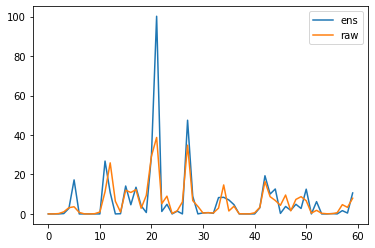

In [106]:
from matplotlib import pyplot as plt
plt.plot(ensdata[:,4500])
plt.plot(oidata_raw[:,4500])
plt.legend(['ens','raw'])

In [108]:
3.3*100

330.0

In [42]:
        popi = oipop[indm, i]
        erri = oidata_err[indm, i].copy()
        erri[erri<0.1] = 0.1
        datai = oidata[indm, i]

In [43]:
            ensdatae = np.nan * np.zeros(len(popi))
            cprobie = cprob[indm, i, e]
            indp0 = cprobie > 1 - popi
            ensdatae[~indp0] = 0

            cs = (cprobie[indp0] - (1 - popi[indp0])) / popi[indp0]
            rn = np.sqrt(2) * erfinv(2*cs-1)
            rn[cs < 3e-5] = - 3.99
            rn[cs >= 0.99997] = 3.99
            ra = datai[indp0] + rn*erri[indp0]

            # back transformation
            ra = sfun_invint(ra, transn, trans_param[i, m])
            ensdatae[indp0] = ra
            ensdata[indm, i, e] = ensdatae

In [126]:
num = np.sum(stndata > -100, axis=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [129]:
num[:]=10
num

array([10, 10, 10, ..., 10, 10, 10])